In [1]:
# -*- coding: utf-8 -*-
from io import open
import os.path
from os import path
import random
import numpy as np
import pickle
import pandas as pd
import scipy.signal
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
#plt.switch_backend('TkAgg')
import matplotlib.ticker as ticker
from torch import nn
from trajectory_dataPrepare8 import *

torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader, valid_loader, WholeSet= get_dataloader(1,100,30)
iters = iter(train_loader)
X_train, y = next(iters)

****************************** ——-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-—— ******************************
---轨迹输入数据结构： torch.Size([1, 100, 26]) ---轨迹输出数据结构： torch.Size([1, 100, 4]) --行为输入数据结构
---轨迹长度： 100 ---预测轨迹长度： 30


In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.n_layers = n_layers
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=0., batch_first=True,bidirectional=False)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc = nn.Linear(hidden_dim*2, output_size)
        self.fc2 = nn.Linear(X_train.shape[2],output_size)
       # self.softmax = nn.Softmax(dim=1)
    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.lstm(x, hidden)
        """
        r_out = torch.mean(r_out,dim=2).squeeze()
        
        output= self.fc2(r_out)
        # shape output to be (batch_size*seq_length, hidden_dim)
        """
        r_out = r_out.contiguous().view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc1(r_out)
        output = self.fc(output)
        output = output.view(batch_size,-1,5)
        output = output[:,-1]
       # output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))    
        return hidden
if torch.cuda.is_available():
    train_on_gpu = True
else:
    train_on_gpu = False

In [4]:
def trajectory_to_behavior_data(x):
    x = x.to(device)
    std = WholeSet.std.repeat(x.shape[0],x.shape[1],1)
    std = std.to(device)
    mn = WholeSet.mn.repeat(x.shape[0],x.shape[1],1)
    mn = mn.to(device)
    rg = WholeSet.range.repeat(x.shape[0],x.shape[1],1)
    rg = rg.to(device)
    input_return = (x*(rg*std)+mn).detach().cpu()
    inputs = torch.from_numpy(input_return[:,:,:-1].detach().cpu().numpy().astype(np.float32))
    inputs = inputs.view(-1,inputs.shape[2])
    y = torch.from_numpy(input_return[:,:,-1].detach().cpu().numpy().astype(np.int))
    y = y.view(-1,1).squeeze()
    return inputs,y

In [5]:
def train(net,epochs,train_loader,valid_loader,clip,lr = 0.0002):
    # train for some number of epochs
    # loss and optimization functions
    loss_min = np.inf
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    counter = 0
    losses_train = []
    losses_valid = []
    accuracies_e = []
    for e in range(epochs):
        # initialize hidden state
        net.train()
        # batch loop
        train_loss = []
        for inputs, labels in train_loader:
            inputs,labels = trajectory_to_behavior_data(inputs)
           # print(inputs.shape,labels.shape,labels)
            h = net.init_hidden(inputs.shape[0])
            h = tuple([each.data for each in h])
            inputs = inputs.unsqueeze(2)
            if (train_on_gpu):
                inputs, labels = torch.from_numpy(inputs.numpy().astype(np.float32)).to(device), labels.long().to(device)
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output, h = net(inputs, h)
            # calculate the loss and perform backprop
          #  print(output.shape,labels.shape)
           # print(output[:1])
            loss = criterion(output, labels)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            train_loss.append(loss.item())
            # loss stats
                # Get validation loss
        val_losses = []
        net.eval()
        accuracies = []
        for inputs, labels in valid_loader:
            inputs,labels = trajectory_to_behavior_data(inputs)
            val_h = net.init_hidden(inputs.shape[0])
            inputs = inputs.unsqueeze(2)
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                   # val_h = tuple([each.data for each in val_h])
            val_h = tuple([each.data for each in val_h])
            if (train_on_gpu):
                inputs, labels = torch.from_numpy(inputs.numpy().astype(np.float32)).to(device), labels.long().to(device)
            #labels = labels.long()
            output, val_h = net(inputs, val_h)
            val_loss = criterion(output, labels)
            _, class_ = torch.max(output, dim=1)
            equal = class_ == labels.view(class_.shape)
            accuracy = torch.mean(equal.type(torch.FloatTensor)).item()
            val_losses.append(val_loss.item())
            accuracies.append(accuracy)               
        net.train()
        losses_train.append(np.mean(train_loss))
        losses_valid.append(np.mean(val_losses))
        accuracies_e.append(np.mean(np.mean(accuracies)))
        print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Loss: {}...".format(np.mean(train_loss)),
                      "Val Loss: {}...".format(np.mean(val_losses)),
                      "val accuracy:{}.".format(np.mean(accuracies))
                     )
        if np.mean(val_losses) < loss_min:
            print('Val loss decreased...')
            torch.save(net.state_dict(),'model/behavior_prediction_25.pth')
            loss_min = np.mean(val_losses)
      #  torch.save(net.state_dict(),'model/lstm_behavior_prediction_each_67.pth')
    print('min loss',loss_min)
    plt.plot(losses_train,color='r',label='train_loss')
    plt.plot(losses_valid,color='g',label='valid_loss')
  #  plt.plot(losses_train,color='r',label='训练损失')
  #  plt.plot(losses_valid,color='g',label='验证损失')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    #plt.title('损失变化')
   # plt.xlabel('迭代次数')
    #plt.ylabel('损失大小')
    plt.legend()
    #plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('image/loss_lstm_behavior_25.svg',dpi=600)
    plt.savefig('image/loss_lstm_behavior_25.png',dpi=600)
    return accuracies_e
 
def test(net,test_loader):
    # Get test data loss and accuracy
    lr = 0.001

    criterion = nn.CrossEntropyLoss()
    test_losses = []  # track loss
    accuracies = []
    net.eval()
    # iterate over test data
    class_correct = np.zeros(5)
    class_total = np.zeros(5)
    classes = ["Keep","Left_turn","Left_change", 'Right_turn',"Right_change"]
    for inputs, y in test_loader:
        inputs,y = trajectory_to_behavior_data(inputs)
        h = net.init_hidden(inputs.shape[0])
        inputs = inputs.unsqueeze(2)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        if (train_on_gpu):
            inputs, y = torch.from_numpy(inputs.numpy().astype(np.float32)).to(device), y.long().to(device)
        # get predicted outputs
       # inputs,y = torch.from_numpy(inputs.numpy().astype(np.float32)),y.long()
        output, h = net(inputs, h)
        
        # calculate loss
        test_loss = criterion(output, y)
        _, class_ = torch.max(output, dim=1)
        equal = class_ == y.view(class_.shape)
        for i in range(y.shape[0]):
            label = y.data[i].item()
            class_correct[label] += equal[i].item()
            class_total[label] += 1
        accuracy = torch.mean(equal.type(torch.FloatTensor)).item()
        test_losses.append(test_loss.item())
        accuracies.append(accuracy)

    # -- stats! -- ##
    # avg test loss
    print('Test Loss: {:.20f}\n'.format(test_loss.item()))
    for i in range(5):
        if class_total[i]>0:
            print('Test Accuracy of {}:{:.4f}({}/{})'.format(classes[i],100*class_correct[i]/class_total[i],
                 int(np.sum(class_correct[i])),
                 int(np.sum(class_total[i]))))
        else:
            print('Test Accuracy of {}:N/A(no examples)'.format(classes[i]))
    print('Test Accuracy(Overall):{:.4f} ({}/{})'.format(100*np.sum(class_correct)/np.sum(class_total),
                                                    int(np.sum(class_correct)),
                                                    int(np.sum(class_total))))
    print("Test loss: {:.10f}".format(np.mean(test_losses)),'Test Accuracy:{}'.format(np.mean(accuracies)))

Epoch: 1/100... Loss: 0.343329496286562... Val Loss: 0.242569370657839... val accuracy:0.899249423456574.
Val loss decreased...
Epoch: 2/100... Loss: 0.23641252369864668... Val Loss: 0.22261750743140044... val accuracy:0.9177598156052154.
Val loss decreased...
Epoch: 3/100... Loss: 0.21696474000404498... Val Loss: 0.23071407622149878... val accuracy:0.918573902726311.
Epoch: 4/100... Loss: 0.1983681052091122... Val Loss: 0.18862344629448038... val accuracy:0.9261316397156368.
Val loss decreased...
Epoch: 5/100... Loss: 0.17971604977117794... Val Loss: 0.17003941438114542... val accuracy:0.9315415704687391.
Val loss decreased...
Epoch: 6/100... Loss: 0.1585078970378743... Val Loss: 0.15565349451907365... val accuracy:0.941778290956593.
Val loss decreased...
Epoch: 7/100... Loss: 0.13528088357055015... Val Loss: 0.13454889149238572... val accuracy:0.9475115479828303.
Val loss decreased...
Epoch: 8/100... Loss: 0.11337279370884137... Val Loss: 0.10419998661535745... val accuracy:0.9602078

Epoch: 69/100... Loss: 0.004439805083433909... Val Loss: 0.010426702819785137... val accuracy:0.9973383382410155.
Epoch: 70/100... Loss: 0.00438090567100694... Val Loss: 0.009889612603068157... val accuracy:0.9977194003020918.
Epoch: 71/100... Loss: 0.004316000794561899... Val Loss: 0.008491894525994399... val accuracy:0.9978926104706375.
Epoch: 72/100... Loss: 0.0042979662125257785... Val Loss: 0.011301655532501464... val accuracy:0.9974769061349557.
Epoch: 73/100... Loss: 0.004279789528493711... Val Loss: 0.008642825526689737... val accuracy:0.997748268772493.
Epoch: 74/100... Loss: 0.004105042251840563... Val Loss: 0.012071338933346823... val accuracy:0.9967147817719065.
Epoch: 75/100... Loss: 0.004057103879047356... Val Loss: 0.009350615026859792... val accuracy:0.997627021671718.
Epoch: 76/100... Loss: 0.004137790641963642... Val Loss: 0.008392953458736042... val accuracy:0.9980831416388307.
Epoch: 77/100... Loss: 0.004020420889142594... Val Loss: 0.008342343407080285... val accur

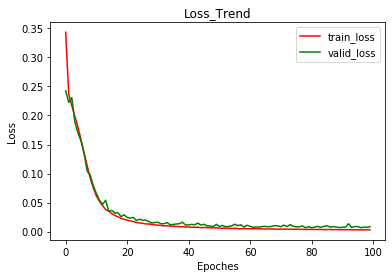

In [5]:
net = LSTM(1,5,256,2) #512,2 0.983  256,2 0.983 ,64 ,2 0.984,32,2,0.983,256,4.0.983
from time import time
if train_on_gpu:
    net.to(device)
start = time()
epochs = 100
accuracy = train(net,epochs,train_loader,valid_loader,clip=5,lr=0.0001)
print('Training time is:',time()-start,'s')

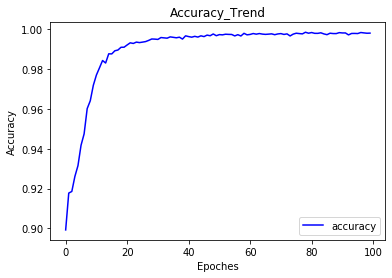

In [6]:
plt.plot(accuracy,color='b',label='accuracy')
plt.title('Accuracy_Trend')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
#plt.plot(accuracy,color='b',label='准确率')
#plt.title('准确率变化')
#plt.xlabel('迭代次数')
#plt.ylabel('准确率')
plt.legend()
plt.savefig('image/accuracy_lstm_behavior_25.svg',dpi=300)
plt.savefig('image/accuracy_lstm_behavior_25.png',dpi=300)

In [6]:
net_test = LSTM(1,5,256,2)
net_test.load_state_dict(torch.load('model/behavior_prediction_25.pth'))
if train_on_gpu:
    net_test.cuda()   
test(net_test,test_loader)

Test Loss: 0.00000329017643707630

Test Accuracy of Keep:99.9809(152166/152195)
Test Accuracy of Left_turn:99.7235(9017/9042)
Test Accuracy of Left_change:99.3557(8635/8691)
Test Accuracy of Right_turn:99.3023(1708/1720)
Test Accuracy of Right_change:98.1959(1524/1552)
Test Accuracy(Overall):99.9134 (173050/173200)
Test loss: 0.0026464868 Test Accuracy:0.9991339498111337
